#  AT&T Spam Detector


# <span style="color:red"><b>TODO & Ideas - TO BE COMMENTED</b></span>

* ~~In 03_bert.ipynb make a test with ``bert-base-uncased`` then ``bert-base-cased`` and compare~~
* ~~Analyze results of the model~~
* ~~Explain the number of trainable parameters of the model~~
* ~~Use plotly to draw a confusion matrix per epoch. Can plotly do that ?~~
* ~~Try over-under sampling (see 02_att_02.ipynb and 02_att_03.ipynb)~~
* Make a test with an additional Dropout layer in the Baseline model to prevent overfitting?
* See ``07_deep_learning\08_Word_Embedding\04-Embedding_for_sentiment_analysis.ipynb``
* https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
* https://medium.com/@samia.khalid/bert-explained-a-complete-guide-with-theory-and-tutorial-3ac9ebc8fa7c
* https://medium.com/@yashvardhanvs/classification-using-pre-trained-bert-model-transfer-learning-2d50f404ed4c
* https://blog.mirkopeters.com/bert-based-transfer-learning-in-nlp-6887b4538bd0
* https://thesai.org/Downloads/Volume12No1/Paper_64-Comparison_of_Deep_and_Traditional_Learning_Methods.pdf
* https://medium.com/towards-data-science/spam-filtering-system-with-deep-learning-b8070b28f9e0
* https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e
* https://www.tensorflow.org/tensorboard/get_started
* https://www.geeksforgeeks.org/sms-spam-detection-using-tensorflow-in-python/
* https://medium.com/@Coursesteach/deep-learning-part-37-bias-variance-3837b4f6caa1
* https://www.kaggle.com/code/bishowlamsal/spam-detector-using-bert
* https://www.kaggle.com/code/kshitij192/spam-email-classification-using-bert


Since we will use TensorFlow for this project, I highly recommend to create a virtual environnement named``att`` (python 3.10 is important for TF)

```
conda create --name att python=3.10
conda activate att
code .
# VSCode will ask to install ipykernel

# Open a terminal in VScode, double check att is current envinment then
conda install tensorflow
conda install pydot
conda install spacy
conda install pandas
conda install wordcloud
conda install scikit-learn 
conda install plotly
conda install nbformat
conda install transformers
python -m spacy download en_core_web_sm

# Final step
pip freeze > ./assets/requirements.txt

```

Once in another brand new environment (<span style="color:red"><b>NOT</b></span> tested yet)
```
conda install --yes --file requirements.txt
```


# Summary of the specs

* https://app.jedha.co/course/projects-deep-learning-ft/att-spam-detector-ft

## Goals
* Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms" content.

## Start simple
* A good <span style="color:orange"><b>deep learing model</b></span> does not necessarily have to be super complicated!

## Transfer learning
* You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!



# EDA

In [50]:
# prelude

import re
#import spacy
import pandas as pd
import numpy as np
import en_core_web_sm
import tensorflow as tf
# import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# from tensorflow.keras import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D



from sklearn.metrics import confusion_matrix
import plotly.express as px


from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618                    # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold
k_random_state  = 42
k_test_size     = 0.3
k_num_words     = 1_000                    # the number of most freq words to keep during tokenization
k_epochs        = 50                       # I tried 10, 20, 50 and 100

In [51]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if col_dtype != "object":
            max_of_col = df[col_name].max()
            min_of_col = df[col_name].min()
            outlier_hi = df[col_name].mean() + 3*df[col_name].std()
            outlier_lo = df[col_name].mean() - 3*df[col_name].std()
        else:
            max_of_col = -1
            min_of_col =  1
            outlier_hi = -1
            outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2) ,
            "min"                 : round(min_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [52]:
# -----------------------------------------------------------------------------
# drop empty cols and duplicates, rename cols...
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "target"}, inplace=True)
    df.rename(columns={"v2": "text"}, inplace=True)

    return df

In [53]:
# df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding="cp1252")
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
print(f"\n\nPreview of the dataset (raw) :")
display(df.head())

df = cleaner(df)
# print(df.shape)

print(f"\n\nPreview of the initial dataset :")
display(df.head())

print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

print(f"\n\nIt's a binary classification problem")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   

print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))



Preview of the dataset (raw) :


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN




Preview of the initial dataset :


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."




The dataset consists of :
	        2 dimensions
	    5_169 observations
	        2 features    


It's a binary classification problem


% of data type :


,types,as_%
object,2,100.0




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
0,target,object,0,0.0,5169,2,1,1,-1,-1,"{'ham': 4516, 'spam': 653}"
1,text,object,0,0.0,5169,5169,1,1,-1,-1,"{'Go until jurong point, crazy.. Available onl..."




% of missing values :


target    0.0
text      0.0
dtype: float64

## <span style="color:orange"><b>Comments :</b></span>
* There is no missing values
* 5k observations. Will it be enough ?
* Unbalanced target

## Spam & ham balance

Nb spam :     653
Nb ham  :   4_516


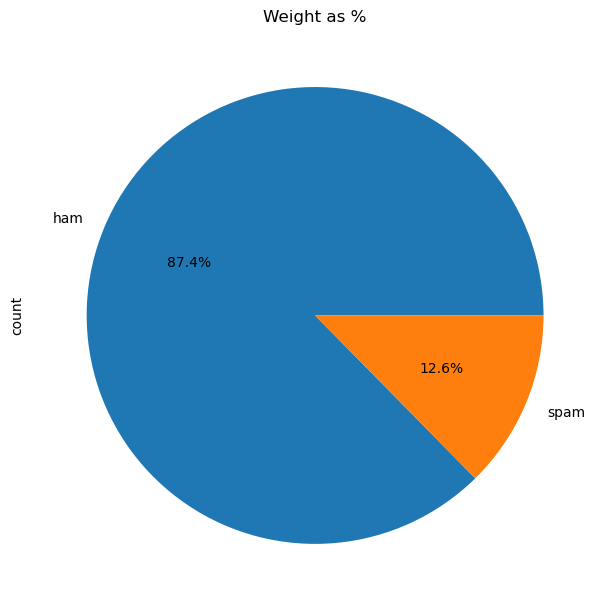

In [54]:
counts = df["target"].value_counts()
print(f"Nb spam : {counts['spam']:>7_}")
print(f"Nb ham  : {counts['ham']:>7_}")

_ = counts.plot.pie(title="Weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* No surprise, the target is heavily unbalanced

# Text processing


## How ham and spam text look like ?

In [55]:
print(f"\n\nHAM : ")
# pd.set_option("display.max_colwidth", 1000)
# print(df[df["target"]=="ham"].head(20))
print(df[df["target"]=="ham"].head(20).to_string())



HAM : 
   target                                                                                                                                                                                                  text
0     ham                                                                                       Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1     ham                                                                                                                                                                         Ok lar... Joking wif u oni...
3     ham                                                                                                                                                     U dun say so early hor... U c already then say...
4     ham                                                                                                                                         Nah I don't t

In [56]:
print(f"\n\nSPAM : ")
print(df[df["target"]=="spam"].head(20).to_string())



SPAM : 
    target                                                                                                                                                                          text
2     spam                   Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
5     spam                          FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
8     spam                WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9     spam                    Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
11    spam                                      SIX chances to wi

## Cleaning

In [57]:
# The 2 lines below can help to print the punctuation signs
# import string 
# string.punctuation

# Remove punctuation  
df["clean_docs"] = df["text"].apply(lambda x: re.sub("[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+"," ", x)) 

# fillna() makes sure NA is replaced with "" so that lowering case do not generate error
df["clean_docs"] = df["clean_docs"].fillna("").apply(lambda x: x.lower())

# df["clean_docs"].head(20)
df


,target,text,clean_docs
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...


## Tokenization

In [58]:
nlp = en_core_web_sm.load()

# Tokenize the cleaned document
df["tokenized_docs"] = df["clean_docs"].fillna("").apply(lambda x: nlp(x))

# remove stop-words, replace words with their lemma
df["tokenized_docs"] = df["tokenized_docs"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
# df["tokenized_docs"].head(20)

# clean up tokenized documents
df["clean_tokens"] = [" ".join(x) for x in df["tokenized_docs"]]

# set the target as boolean value (spam=1) 
df["target"] = df["target"].map({"ham":0,"spam":1})
df


,target,text,clean_docs,tokenized_docs,clean_tokens
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[2nd, time, try, 2, contact, u, , u, win, å£7...",2nd time try 2 contact u u win å£750 pound p...
5568,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,"[ì, , b, go, esplanade, fr, home]",ì b go esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...,"[pity, , mood, , suggestion]",pity mood suggestion
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[guy, bitching, act, like, interested, buy, we...",guy bitching act like interested buy week give...


In [59]:
# max_words = df['clean_tokens'].apply(lambda x: len(x.split())).max()
# print(max_words)


## Word Cloud

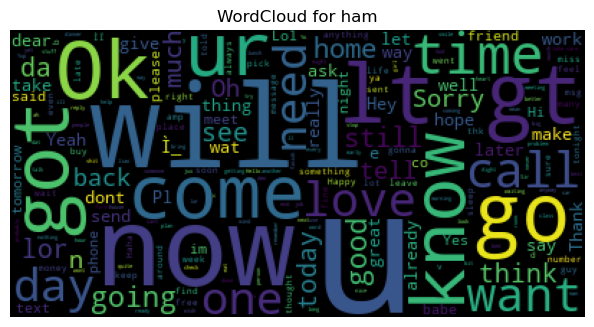

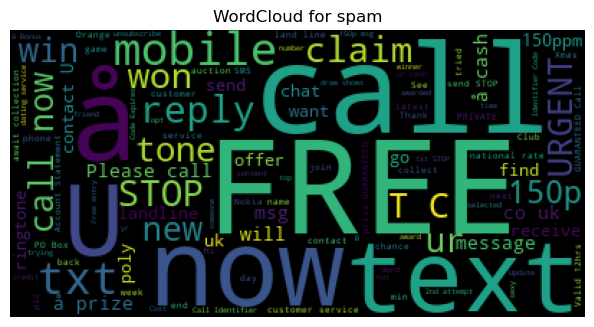

In [60]:
for i in set(df["target"]):
    words = ""
    for doc in df[df["target"] == i]["text"]:
        words += doc + " "
    wordcloud = WordCloud().generate(words)
    plt.figure(figsize = (k_Height, k_Width))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"WordCloud for {'spam' if i==1 else 'ham'}")
    plt.show()

### <span style="color:orange"><b>Comments :</b></span>

* With no surprise "free", "call", "now"... are dominant in spams sms
* Surprisingly "sex" and "viagra" are missing 😁

## Word occurrences

In [61]:
def word_occurences_report(target):
    df_tmp = " ".join(df[df["target"] == target]["clean_tokens"])
    df_tmp = pd.DataFrame(df_tmp.split(" "))
    df_tmp = df_tmp.value_counts(ascending=False)

    df_tmp = df_tmp.reset_index()  
    df_tmp.columns = ["word", "occurrences"]  
    df_tmp.set_index("word", inplace=True)  
    display(df_tmp)

    # print(f"About words in ham :")
    print(f"{len(df_tmp):>6_} differents words")
    print(f"{df_tmp['occurrences'].sum():>6_} occurrences")
    pareto = int(df_tmp['occurrences'].sum()*0.8)
    print(f"{pareto:>6_} = 80% of thoses occurrences")

    i = 100
    while df_tmp['occurrences'].head(i).sum()<pareto:
        i+=100

    print(f"{i:6_} ({100*i/len(df_tmp):.0f} %) words are needed to cover 80% of the occurrences")
    print(f"\n\n\n")
    return

In [62]:
print(f"About words in spam :")
word_occurences_report(1)

print(f"About words in ham :")
word_occurences_report(0)


About words in spam :


,occurrences
word,
,4422
free,195
2,171
txt,142
u,141
...,...
complete,1
complementary,1
compensation,1


 2_558 differents words
15_527 occurrences
12_421 = 80% of thoses occurrences
   500 (20 %) words are needed to cover 80% of the occurrences




About words in ham :


,occurrences
word,
,15231
u,902
go,310
2,302
come,299
...,...
breath,1
breakin,1
breakfast,1


 5_727 differents words
47_980 occurrences
38_384 = 80% of thoses occurrences
   700 (12 %) words are needed to cover 80% of the occurrences






## Encoding

In [63]:
# oov_token= out of vocabulary token
# When the oov_token is specified in the tokenizer, words not present in the learned vocabulary will be replaced by this token. 
# This enables the model to handle new words that appear in test or inference data, while reducing the risk of errors or inaccuracies.
# In a new sentence, 2 unknown words will be represented by the OOV token, preserving information even if the model hasn't seen these words before

# If oov_token not specified any word not in the vocabulary will be ignored and not tokenized
# This may result in the loss of important information during inference or testing.

# keep the 1_000 most frequents words during tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=k_num_words, oov_token="_UNKNOWN_") 
tokenizer.fit_on_texts(df["clean_tokens"])
df["sms_encoded"] = tokenizer.texts_to_sequences(df["clean_tokens"])
df


,target,text,clean_docs,tokenized_docs,clean_tokens,sms_encoded
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...,"[1, 253, 445, 468, 921, 37, 60, 272, 922, 75, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni,"[14, 207, 495, 301, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...,"[15, 372, 3, 762, 715, 46, 1, 1, 496, 1, 1, 1,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c,"[2, 129, 154, 1, 2, 56]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live,"[716, 24, 5, 659, 175]"
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[2nd, time, try, 2, contact, u, , u, win, å£7...",2nd time try 2 contact u u win å£750 pound p...,"[309, 19, 57, 3, 106, 2, 2, 46, 1, 334, 84, 3,..."
5568,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,"[ì, , b, go, esplanade, fr, home]",ì b go esplanade fr home,"[45, 97, 5, 1, 581, 28]"
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...,"[pity, , mood, , suggestion]",pity mood suggestion,"[1, 1, 1]"
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[guy, bitching, act, like, interested, buy, we...",guy bitching act like interested buy week give...,"[121, 1, 1, 16, 979, 93, 44, 326, 15]"


## Padding

In [64]:
# Tensorflow cannot create a tensor dataset based on lists
# We have to store encoded sms into a numpy array before creating the tensorflow dataset
# However, not all the sequences are the same length
# This is where `tf.keras.preprocessing.sequence.pad_sequences()` comes in 
# It will add zero padding at the beginning (`padding="pre"`) or at the end (`padding="post"`) of our sequences so they all have equal length
sms_padded = tf.keras.preprocessing.sequence.pad_sequences(df["sms_encoded"], padding="post")
print(sms_padded)
print(sms_padded.shape)

# max_words = df['clean_tokens'].apply(lambda x: len(x.split())).max()
# print(max_words)
# 77

[[  1 253 445 ...   0   0   0]
 [ 14 207 495 ...   0   0   0]
 [ 15 372   3 ...   0   0   0]
 ...
 [  1   1   1 ...   0   0   0]
 [121   1   1 ...   0   0   0]
 [  1 367   0 ...   0   0   0]]
(5169, 77)


## Split

In [65]:
# stratify
X_train, X_test, y_train, y_test = train_test_split(sms_padded, df["target"], test_size = k_test_size, random_state = k_random_state, stratify = df["target"])

### <span style="color:orange"><b>Comments :</b></span>

* No over/under sampling on ``X_train``, ``y_train``
* See ``02_att_02.ipynb`` or ``02_att_03.ipynb``

## Create Tensor

In [66]:
# creates a TensorFlow Dataset object to be used for data loading, batching, shuffling, and preprocessing when training the model
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [67]:
# Create generators, making sure that data are blended/mixed and divided into batches of 64 observations 
train_batch = train_ds.shuffle(len(train_ds)).batch(64)
test_batch = test_ds.shuffle(len(test_ds)).batch(64)

# for sms, ham_spam in train_batch.take(1):
#   print(sms, ham_spam)

# print()
# print(sms.shape)

tf.Tensor(
[[287  60  53 ...   0   0   0]
 [ 26   1  65 ...   0   0   0]
 [  1   2 814 ...   0   0   0]
 ...
 [  1   1   1 ...   0   0   0]
 [610  85 128 ...   0   0   0]
 [ 40   2  59 ...   0   0   0]], shape=(64, 77), dtype=int32) tf.Tensor(
[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int64)

(64, 77)


# Using a Baseline Model


In [68]:
sequence_length = sms_padded.shape[1]
model = tf.keras.Sequential([
    # This Embedding layer converts integer-encoded words (from the tokenizer) into dense vectors of size 8 
    # tokenizer.num_words should be equal to k_num_words
    # +1 because TensorFlow reserves an index for padding or the OOV token
    # sms.shape[1] is the length of the input sequence. See the output of the previous cell (77)
    # For the output I tried : 16 8 4 and 2
    # I like 8
    
    # tf.keras.layers.Embedding(tokenizer.num_words + 1, 8, input_shape=[sms.shape[1],], name="embedding"),
    tf.keras.layers.Embedding(tokenizer.num_words + 1, 8, input_shape=[sequence_length], name="embedding"),

    # Global average pooling
    # Reduces the dimensionality by averaging the vectors across the sequence length
    # The model loose the order of the words but we don't care  
    tf.keras.layers.GlobalAveragePooling1D(),

    # Fully connected (Dense) layer with 16 neurons. 
    # relu activation function introduces non-linearity (this helps the model to capture more complex patterns)
    tf.keras.layers.Dense(16, activation="relu"),

    # Since this is a binary classification problem (based on the sigmoid activation), there's a single output neuron. 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 8)             8008      
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


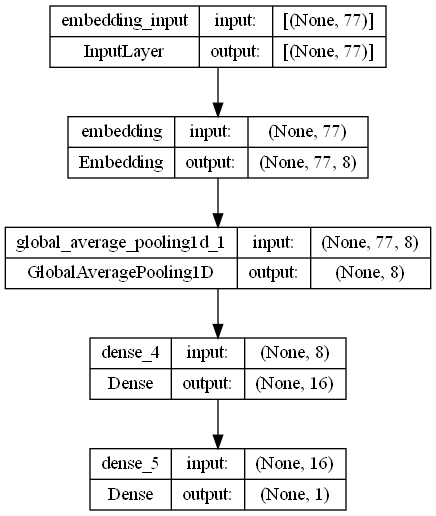

In [69]:
path = Path(f"{k_Current_dir/k_AssetsDir/'baseline_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

## <span style="color:orange"><b>Comments :</b></span>

About the number of trainable parameters of the model

```
Inputs                 : 1000 words    (see k_num_words in prelude)
Embedding layer        :  8 neurons => (1000 + 1) * 8 = 8008 params
GlobalAveragePooling1D :    average => no params      =    0 params
Dense layer            : 16 neurons => 8  * 16 + 16   =  144 params
Dense layer            :  1 neuron  => 16 *  1 +  1   =   17 params
                                                TOTAL = 8169 params
```


In [70]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"]       # name=... avoid recall_1 for example
)

In [71]:
confusion_matrices = []

def get_data_from_dataset(dataset):
    features = []
    labels = []
    for batch_features, batch_labels in dataset:
        features.append(batch_features.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

class ConfusionMatrixCallback(tf.keras.callbacks.Callback):             # inherit from tf.keras.callbacks.Callback
    def __init__(self, val_data):
        # store data once
        self.val_data = val_data                                        

    def on_epoch_end(self, epoch, logs=None):
        # extract features and labels from validation set
        val_features, val_labels = get_data_from_dataset(self.val_data)
        
        # make prediction with validation features
        val_pred = (self.model.predict(val_features) > 0.5).astype("int32")
        
        # compute the associated confusion matrix
        cm = confusion_matrix(val_labels, val_pred)

        # flip the 2 lines just to make sure it looks like sklearn.metrics.confusion_matrix
        cm_flipped = np.flipud(cm)
        
        confusion_matrices.append(cm_flipped)

history = model.fit(
    train_batch,
    epochs=k_epochs,
    validation_data=test_batch,
    callbacks=[ConfusionMatrixCallback(test_batch)]
)

Epoch 1/50
57/57 [==============================] - 1s 12ms/step - loss: 0.6608 - recall: 0.0700 - precision: 0.1085 - accuracy: 0.8098 - val_loss: 0.6182 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 2/50
57/57 [==============================] - 1s 9ms/step - loss: 0.5652 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.5048 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 3/50
57/57 [==============================] - 0s 8ms/step - loss: 0.4418 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3878 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 4/50
57/57 [==============================] - 0s 8ms/step - loss: 0.3602 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3466 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 5/50
57/57 [==============================] - 0s 

## Evaluating

### <span style="color:orange"><b>Sync point :</b></span>

<p align="center">
<img src="./assets/metrics.png" alt="drawing" width="400"/>
<p>

* Sms identified as spam (=1)
* Can I accept spam in my sms? I don't know...
* Can I accept to see an sms from my beloved CEO classified as spam? No! 
* So I want FP to tend towards 0 and precision $\frac{TP}{TP+FP}$ towards 1 (even if the recall, $\frac{TP}{TP+FN}$, is not that great )
* I decide to favour precision over recall

Just to make sure...
* **Overfitting**
    * If accuracy continues to increase on training but starts to decrease or stagnate on validation
    * this indicates overfitting.

* **Underfitting** 
    * If the loss curves do not decrease 
    * or 
    * If accuracy remains low
    * this could indicate that the model has not yet learned sufficiently.


In [72]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

### Loss

Saving figure baseline_loss


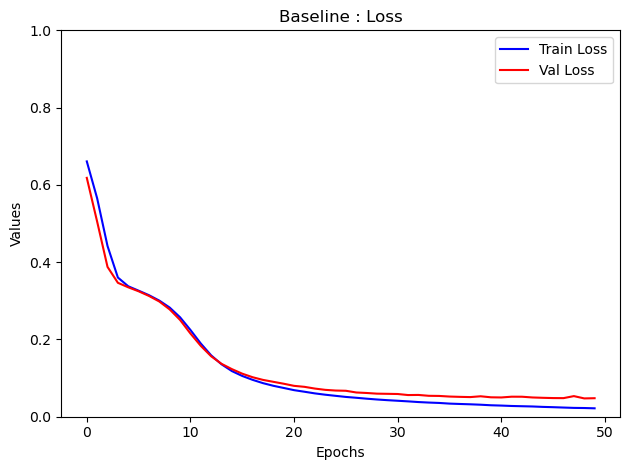

[[0.028847,
  0.027803,
  0.027154,
  0.026525,
  0.025438,
  0.024669,
  0.023745,
  0.022854,
  0.022517,
  0.021744]]

[[0.04985,
  0.051839,
  0.051736,
  0.049849,
  0.048958,
  0.048273,
  0.048115,
  0.053346,
  0.04739,
  0.047914]]

In [73]:
# "val_" stands for validation
# history.history.keys()

plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_loss", "png")
plt.show()


# display(history.history['loss'][-10:])
display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])


#### <span style="color:orange"><b>Comments :</b></span>
* Interpretation
    * The loss measures the error of the model on the training data
    * The learning rate seems OK because the curve shows a drop and then a plateau
    * The 2 curves don't separate immediately. The model doesn't learn "by heart". This is a good indicator
    * Validation loss rises while train loss remains on its plateau. This is also a good sign
* Analysis
    * A loss of 0.05 is relatively low, indicating that the model has learned the characteristics of the data pretty well 
    * However, a low loss does not necessarily mean that the model is perfect 
    * See comments about other metrics below

### Accuracy

Saving figure baseline_accuracy


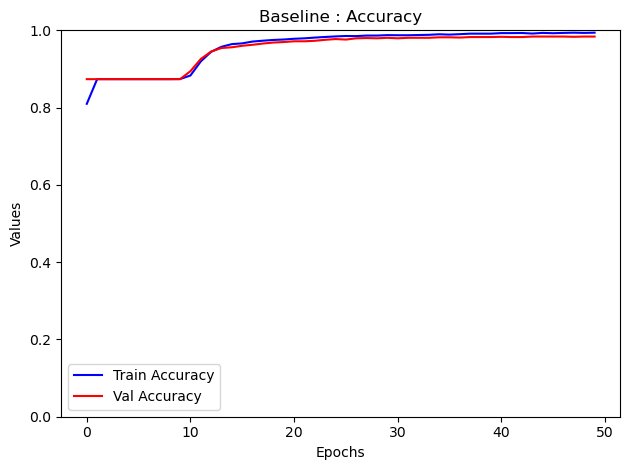

[[0.992814,
  0.992814,
  0.99309,
  0.991708,
  0.993366,
  0.992537,
  0.993366,
  0.993919,
  0.993366,
  0.993919]]

[[0.983237,
  0.982592,
  0.982592,
  0.983881,
  0.983881,
  0.983881,
  0.983881,
  0.983237,
  0.983881,
  0.983881]]

In [74]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline : Accuracy")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_accuracy", "png")
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])


#### <span style="color:orange"><b>Comments :</b></span>
* Interpretation
    * Accuracy measures the total proportion of correct predictions (TP + TN) out of all predictions made (all cells of the matrix above)
    * Diagonal of the matrix (see above, synch point)
    * An accuracy of 0.985 means that the model correctly classifies 98.5% of emails
* Analysis: 
    * High accuracy is generally a good sign
    * **BUT** in a spam detection problem where the classes are unbalanced (much more non-spam than spam), high accuracy can be misleading 
    * For example, predicting that all emails are non-spam could give a good accuracy if spam is rare

### Precision

Saving figure baseline_precision


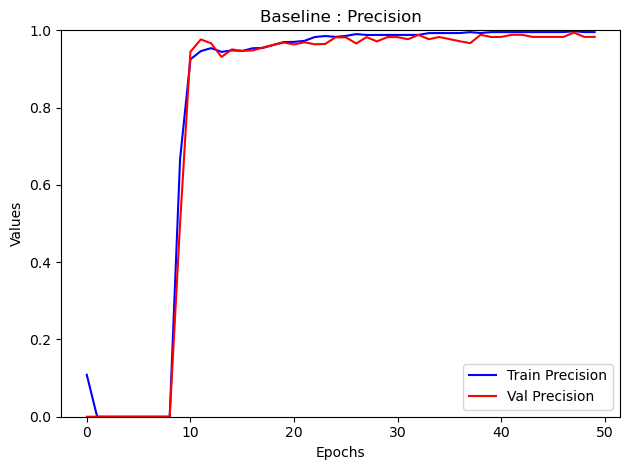

[[0.995402,
  0.995402,
  0.995413,
  0.99536,
  0.995423,
  0.995392,
  0.995423,
  0.997712,
  0.995423,
  0.995444]]

[[0.982955,
  0.988439,
  0.988439,
  0.983051,
  0.983051,
  0.983051,
  0.983051,
  0.994186,
  0.983051,
  0.983051]]

In [75]:
plt.plot(history.history["precision"], color="b", label="Train Precision")
plt.plot(history.history["val_precision"], color="r", label="Val Precision")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline : Precision")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_precision", "png")
plt.show()

display([[round(f, 6) for f in history.history['precision'][-10:]]])
display([[round(f, 6) for f in history.history['val_precision'][-10:]]])


#### <span style="color:orange"><b>Comments :</b></span>
* Interpretation
    * Precision measures the proportion of true positives (sms correctly identified as spam) versus all sms classified as spam by the model (TP + FP). 
    * Right hand side column of the matrix above
    * A precision of 0.994 means that when the model predicts that an sms is spam, it is right 99.4% of the time.
* Analysis
    * Precision is excellent and this is what we want
    * The model is very effective at minimizing false positives, i.e. non-spam sms wrongly classified as spam.

### Recall

Saving figure baseline_recall


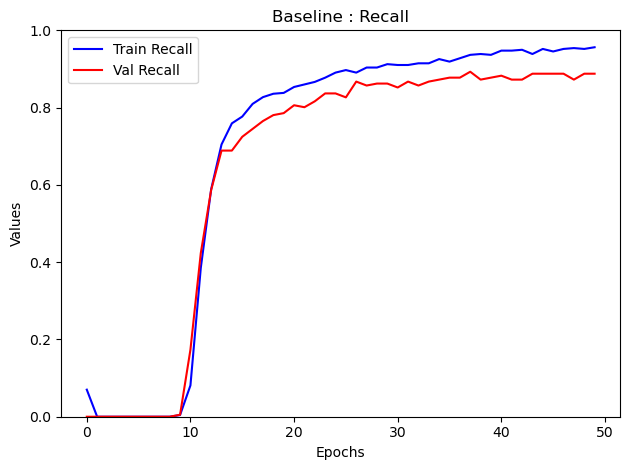

[[0.947484,
  0.947484,
  0.949672,
  0.938731,
  0.95186,
  0.945295,
  0.95186,
  0.954048,
  0.95186,
  0.956236]]

[[0.882653,
  0.872449,
  0.872449,
  0.887755,
  0.887755,
  0.887755,
  0.887755,
  0.872449,
  0.887755,
  0.887755]]

In [76]:
plt.plot(history.history["recall"], color="b", label="Train Recall")
plt.plot(history.history["val_recall"], color="r", label="Val Recall")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline : Recall")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_recall", "png")
plt.show()

display([[round(f, 6) for f in history.history['recall'][-10:]]])
display([[round(f, 6) for f in history.history['val_recall'][-10:]]])


#### <span style="color:orange"><b>Comments :</b></span>


* Interpretation
    * Recall (AKA sensitivity) measures the proportion of true positives (correctly identified spam sms) to all true spam (TP + FN)
    * Bottom line of the matrix above
    * A recall of 0.892 means that the model correctly detects 89.2% of sms that are really spam
* Analysis
    * Although the recall is relatively high, it is still missing around 10.8% of spam (false negatives)

In [77]:
def f1_calculus(name, rec, prec):
    df_tmp=pd.DataFrame()
    df_tmp[name] = 2*np.array(rec)*np.array(prec)/(np.array(rec)+np.array(prec)+tf.keras.backend.epsilon()) # epsilon avoid runtimeWarning: divide by zero encountered in divide...
    return df_tmp

### F1 Score

Saving figure baseline_f1


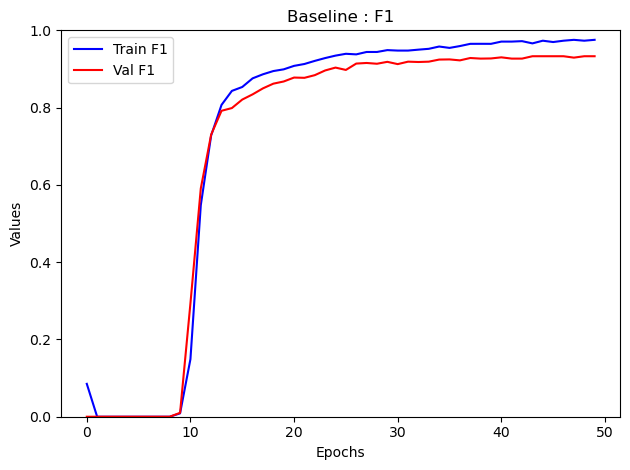

,f1
40,0.970852
41,0.970852
42,0.972004
43,0.966216
44,0.973154
45,0.969697
46,0.973154
47,0.975391
48,0.973154
49,0.975446


,val_f1
40,0.930107
41,0.926829
42,0.926829
43,0.932976
44,0.932976
45,0.932976
46,0.932976
47,0.929348
48,0.932976
49,0.932976


In [78]:
df_tmp = f1_calculus("f1", history.history["recall"], history.history["precision"])
df_val_tmp = f1_calculus("val_f1", history.history["val_recall"], history.history["val_precision"])

plt.plot(df_tmp["f1"], color="b", label="Train F1")
plt.plot(df_val_tmp["val_f1"], color="r", label="Val F1")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Baseline : F1")
plt.legend()
plt.ylim(0,1)
save_fig("baseline_f1", "png")
plt.show()

display(df_tmp.tail(10))
display(df_val_tmp.tail(10))




#### <span style="color:orange"><b>Comments :</b></span>
* Interpretation: 
    * F1 score provides a balanced measure of the model when there's a trade-off between precision and recall 
    * It is the harmonic mean between precision and recall
    * An F1 score of 0.94 shows that the model has a good balance between precision and recall
* Analysis: 
    * The F1 score confirms that the model handles the trade-off between precision and recall pretty well
    * This is crucial in spam detection problems where false negatives (undetected spam sms) can be annoying. 
        * It is great to NOT have true sms in spam but it could be great to have no spam at all in our sms

### Confusion matrix (animated)

In [79]:
def plot_confusion_matrices(confusion_matrices):
    epochs = range(1, k_epochs + 1)
    frames = []

    # Create a frame per epoch
    for epoch, cm in zip(epochs, confusion_matrices):
        annotations = [[f'{value}' for value in row] for row in cm]
        frame = go.Frame(data=[go.Heatmap(
            z=cm, 
            text=annotations,
            colorscale='Viridis',                       # mimic default color of sklearn.metrics.confusion_matrix()
            hoverinfo='skip',                           # ! Hide hover info (x, y, z)
            showscale=True,                             # colorbar visible
            texttemplate="%{text}",                     # string to be displayed in the cells
            textfont={"size": 14},  
        )], name=f"Epoch {epoch}")
        frames.append(frame)

    # Initialization with the first confusion matrix
    fig = go.Figure(
        data=[go.Heatmap(
            z=confusion_matrices[0], 
            text=[[f'{value}' for value in row] for row in confusion_matrices[0]], 
            colorscale='Viridis',
            hoverinfo='skip',  
            showscale=True,  
            texttemplate="%{text}",  
            textfont={"size": 14},  
        )],
        layout=go.Layout(
            autosize=False,
            width=1000,
            height=1000,
            title="Animated confusion matrix",
            xaxis_title="Predicted label",
            yaxis_title="True Label",
            # Make sure 0 is on top and 1 is bottom on y axis 
            # Make sure we read "Ham" and "Spam"
            xaxis=dict(
                tickvals=[0, 1], 
                ticktext=["Ham", "Spam"]
            ),
            yaxis=dict(
                tickvals=[0, 1],  
                ticktext=["Spam", "Ham"],  
                categoryorder="array",  
                categoryarray=[1, 0]  
            ),
            updatemenus=[{
                'type': 'buttons',
                'buttons': [{
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {
                        'frame': {'duration': 500, 'redraw': True},
                        'fromcurrent': True,
                        'mode': 'immediate',
                    }]
                }]
            }]
        ),
        frames=frames  # assign frames to the Figure
    )

    # Add a slider
    fig.update_layout(
        sliders=[{
            'steps': [{
                'args': [[f"Epoch {epoch}"], {'frame': {'duration': 500, 'redraw': True}}],
                'label': f'Epoch {epoch}',
                'method': 'animate'
            } for epoch in epochs],
            'currentvalue': {'prefix': 'Epoch: '}
        }]
    )
    fig.show()

plot_confusion_matrices(confusion_matrices)

### <span style="color:orange"><b>Conclusion (baseline model evaluation) :</b></span>
* Overall, the baseline model performs well and have good metrics
* However, there are a few areas for improvement
    * Recall (89% => 11%) 
    * With the others model, let's try to improve the recall without loosing to much on the precision
    * Is it possible with such small dataset ?
    * Should we consider techniques to balance the classes (SMOTE...)?
    * Should we put the model in production and collect feedback and see how it goes?

# Using RNN with LSTM

* Recurrent Neural Networks
* Long Short-Term Memory
* Advantages:
    * Efficiently capture word relationships
    * Handles long, complex sequences well
* Disadvantages:
    * Much slower to train than CNN-type models (see below)
    * Risk of overlearning if data is limited (which is the case here. 5K sms)

In [80]:
model = tf.keras.Sequential([
    # slow : 12 min for 100 epochs
    # tf.keras.layers.Embedding(tokenizer.num_words + 1, 64, input_shape=[sms.shape[1],], name="embedding"),
    # tf.keras.layers.LSTM(units=64, return_sequences=True, name="lstm_1"),  
    # tf.keras.layers.LSTM(units=32, return_sequences=False, name="lstm_2"), 
    # tf.keras.layers.Dense(16, activation='relu', name="dense_1"),
    # tf.keras.layers.Dense(1, activation="sigmoid", name="dense_2")

    tf.keras.layers.Embedding(tokenizer.num_words + 1, 16, input_shape=[sms.shape[1],], name="embedding"),
    tf.keras.layers.LSTM(units=16, return_sequences=True, name="lstm_1"),  
    tf.keras.layers.LSTM(units=8, return_sequences=False, name="lstm_2"), 
    tf.keras.layers.Dense(8, activation='relu', name="dense_1"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="dense_2")

    # ! Never tried see https://medium.com/towards-data-science/spam-detection-in-emails-de0398ea3b48
    # Creating an embedding layer to vectorize
    # model.add(Embedding(max_feature, embedding_vector_length, input_length=max_len))
    # Addding Bi-directional LSTM
    # model.add(Bidirectional(tf.keras.layers.LSTM(64)))
    # Relu allows converging quickly and allows backpropagation
    # model.add(Dense(16, activation='relu'))
    # Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
    # model.add(Dropout(0.1))
    # Adding sigmoid activation function to normalize the output
    # model.add(Dense(1, activation='sigmoid'))

])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 16)            16016     
                                                                 
 lstm_1 (LSTM)               (None, 77, 16)            2112      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


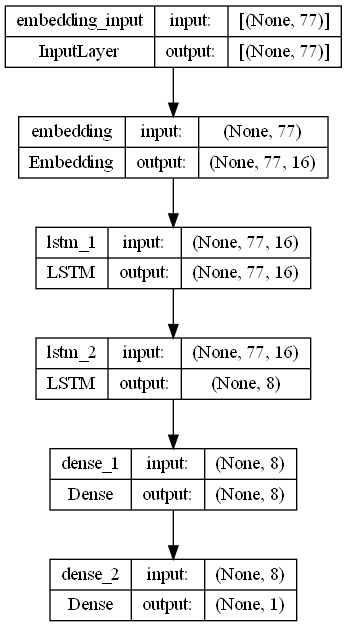

In [81]:
path = Path(f"{k_Current_dir/k_AssetsDir/'lstm_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

In [82]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"]       # name=... avoid recall_1 for example
)

In [83]:
history = model.fit(
    train_batch,
    epochs = k_epochs,
    validation_data=test_batch,
)

Epoch 1/50
57/57 [==============================] - 11s 87ms/step - loss: 0.4726 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3798 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 2/50
57/57 [==============================] - 4s 64ms/step - loss: 0.3798 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3797 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 3/50
57/57 [==============================] - 4s 79ms/step - loss: 0.3798 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3796 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 4/50
57/57 [==============================] - 4s 64ms/step - loss: 0.3798 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3794 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 5/50
57/57 [=========================

KeyboardInterrupt: 

Saving figure lstm_loss


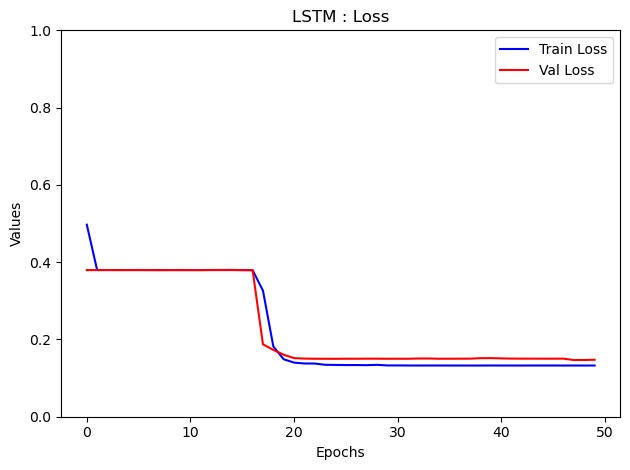

[[0.132469,
  0.132512,
  0.132445,
  0.132561,
  0.132529,
  0.132559,
  0.132464,
  0.132485,
  0.132505,
  0.132539]]

[[0.15097,
  0.150437,
  0.150271,
  0.150274,
  0.150196,
  0.150212,
  0.150289,
  0.146687,
  0.146791,
  0.147504]]

In [36]:
plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("LSTM : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("lstm_loss", "png")
plt.show()

# display(history.history['loss'][-10:])
display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])

Saving figure lstm_accuracy


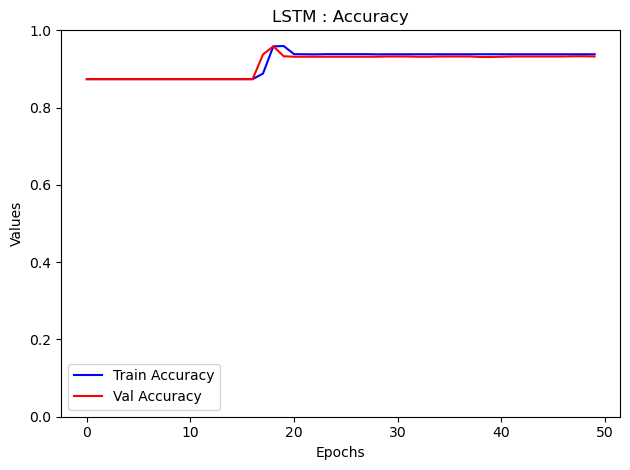

[[0.938087,
  0.938087,
  0.938087,
  0.938087,
  0.938087,
  0.938087,
  0.938087,
  0.938087,
  0.938087,
  0.938087]]

[[0.931657,
  0.932302,
  0.932302,
  0.932302,
  0.932302,
  0.932302,
  0.932302,
  0.932947,
  0.932947,
  0.932302]]

In [37]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("LSTM : Accuracy")
plt.legend()
plt.ylim(0,1)
save_fig("lstm_accuracy", "png")
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])

### <span style="color:orange"><b>Comments :</b></span>
* Let's try another model...


# Using a CNN model 

* CNNs can be used for text classification since they can capture local patterns (phrases or word combinations).
* Advantages:
    * Quick to train
    * Effective for capturing local features
* Disadvantages:
    * Can be less effective at capturing long-distance relationships in text
    * We should not have issue here since sms are short

In [38]:
model = tf.keras.Sequential([
    # tf.keras.layers.Embedding(input_dim=k_num_words, output_dim=embedding_dim, input_length=sms.shape[1]),
    # tf.keras.layers.Embedding(tokenizer.num_words + 1, 8, input_shape=[sms.shape[1],], name="embedding"),
    
    # Might be too complex
    # tf.keras.layers.Embedding(tokenizer.num_words + 1, 128, input_shape=[sms.shape[1],], name="embedding"),
    # tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    # tf.keras.layers.GlobalMaxPooling1D(),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(1, activation='sigmoid') 

    tf.keras.layers.Embedding(tokenizer.num_words + 1, 16, input_shape=[sms.shape[1],], name="embedding"),
    tf.keras.layers.Conv1D(filters=8, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 16)            16016     
                                                                 
 conv1d (Conv1D)             (None, 73, 8)             648       
                                                                 
 global_max_pooling1d (Globa  (None, 8)                0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                      

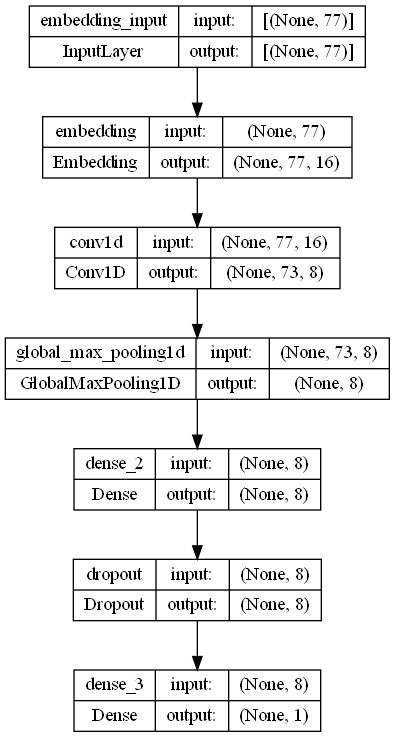

In [39]:
path = Path(f"{k_Current_dir/k_AssetsDir/'cnn_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)

In [40]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    # metrics=['accuracy']),
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"]       # name=... avoid recall_1 for example
)


In [41]:
history = model.fit(
    train_batch,
    epochs = k_epochs,
    validation_data=test_batch,
)

Epoch 1/50
57/57 [==============================] - 2s 14ms/step - loss: 0.5537 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8648 - val_loss: 0.4062 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 2/50
57/57 [==============================] - 0s 7ms/step - loss: 0.4201 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3501 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 3/50
57/57 [==============================] - 0s 8ms/step - loss: 0.3593 - recall: 0.0044 - precision: 1.0000 - accuracy: 0.8742 - val_loss: 0.2798 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 4/50
57/57 [==============================] - 1s 9ms/step - loss: 0.2691 - recall: 0.2188 - precision: 0.9174 - accuracy: 0.8988 - val_loss: 0.1673 - val_recall: 0.5357 - val_precision: 1.0000 - val_accuracy: 0.9413
Epoch 5/50
57/57 [==============================] - 0s 7ms/step - loss:

## Evaluating

Saving figure cnn_loss


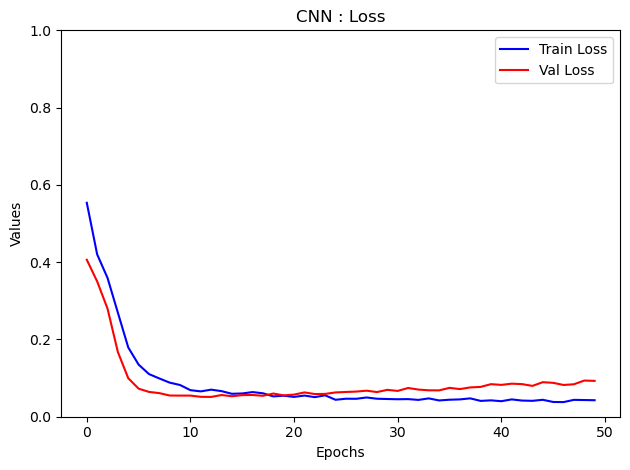

[[0.04016,
  0.044817,
  0.041808,
  0.04116,
  0.043825,
  0.038184,
  0.037843,
  0.043644,
  0.043179,
  0.042698]]

[[0.082404,
  0.085522,
  0.084406,
  0.079807,
  0.089377,
  0.0877,
  0.08218,
  0.083962,
  0.093588,
  0.092813]]

In [42]:
plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("CNN : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("cnn_loss")
plt.show()

# display(history.history['loss'][-10:])
display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])


### <span style="color:orange"><b>Comments :</b></span>
* Note how to model has been simplyfied
* Also note the a dropout layer (randomly remove some features) help to fight overfitting
* We could try to apply L1 or L2 regularization (add a cost to the loss function) 


Saving figure cnn_accuracy


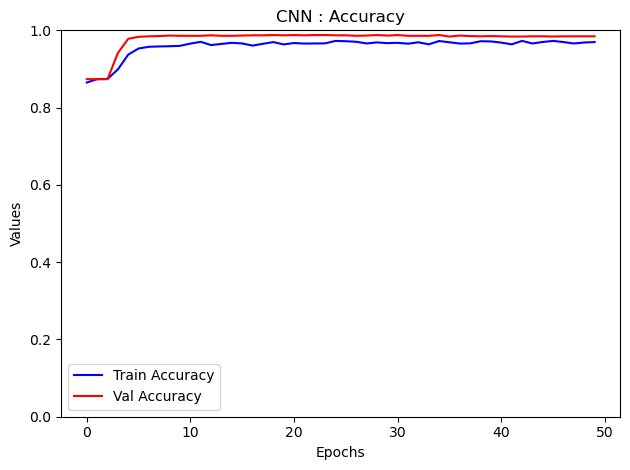

[[0.968215,
  0.963792,
  0.972637,
  0.966003,
  0.969873,
  0.972637,
  0.969596,
  0.966003,
  0.968491,
  0.969596]]

[[0.984526,
  0.983881,
  0.983881,
  0.984526,
  0.984526,
  0.983881,
  0.984526,
  0.984526,
  0.984526,
  0.984526]]

In [43]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("CNN : Accuracy")
plt.legend()
plt.ylim(0,1)
save_fig("cnn_accuracy")
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])


Saving figure cnn_precision


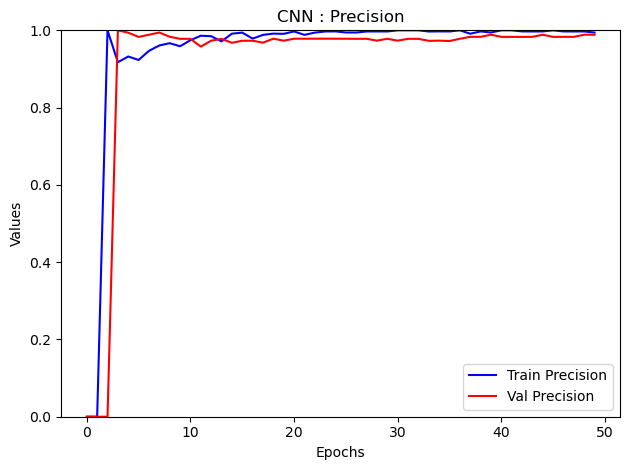

[[1.0,
  1.0,
  0.997222,
  0.997024,
  0.997143,
  1.0,
  0.997135,
  0.997024,
  0.997101,
  0.994302]]

[[0.983146,
  0.983051,
  0.983051,
  0.983146,
  0.988636,
  0.983051,
  0.983146,
  0.983146,
  0.988636,
  0.988636]]

In [44]:
plt.plot(history.history["precision"], color="b", label="Train Precision")
plt.plot(history.history["val_precision"], color="r", label="Val Precision")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("CNN : Precision")
plt.legend()
plt.ylim(0,1)
save_fig("cnn_precision")
plt.show()

display([[round(f, 6) for f in history.history['precision'][-10:]]])
display([[round(f, 6) for f in history.history['val_precision'][-10:]]])


Saving figure cnn_recall


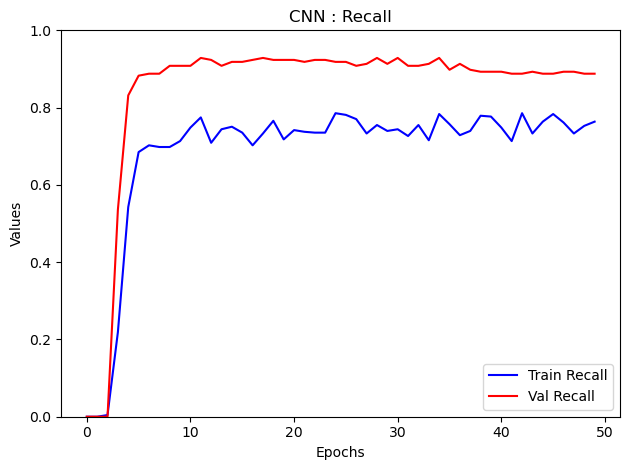

[[0.748359,
  0.713348,
  0.785558,
  0.733042,
  0.763676,
  0.78337,
  0.761488,
  0.733042,
  0.752735,
  0.763676]]

[[0.892857,
  0.887755,
  0.887755,
  0.892857,
  0.887755,
  0.887755,
  0.892857,
  0.892857,
  0.887755,
  0.887755]]

In [45]:
plt.plot(history.history["recall"], color="b", label="Train Recall")
plt.plot(history.history["val_recall"], color="r", label="Val Recall")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("CNN : Recall")
plt.legend()
plt.ylim(0,1)
save_fig("cnn_recall")
plt.show()

display([[round(f, 6) for f in history.history['recall'][-10:]]])
display([[round(f, 6) for f in history.history['val_recall'][-10:]]])


Saving figure cnn_f1


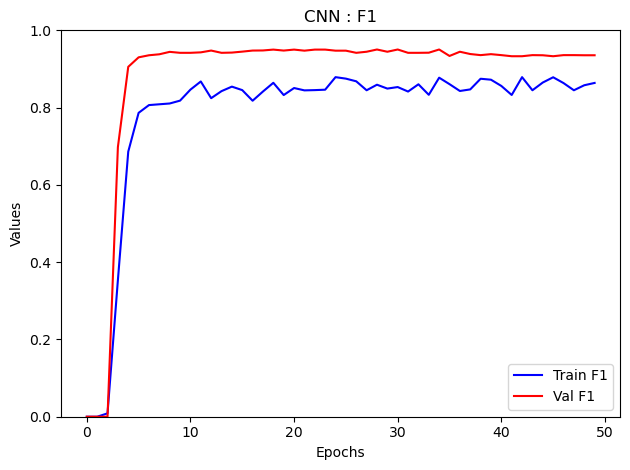

,f1
40,0.856070
41,0.832695
42,0.878825
43,0.844893
44,0.864932
45,0.878528
46,0.863524
47,0.844893
48,0.857855
49,0.863861


,val_f1
40,0.935829
41,0.932976
42,0.932976
43,0.935829
44,0.935484
45,0.932976
46,0.935829
47,0.935829
48,0.935484
49,0.935484


In [46]:
df_tmp = f1_calculus("f1", history.history["recall"], history.history["precision"])
df_val_tmp = f1_calculus("val_f1", history.history["val_recall"], history.history["val_precision"])

plt.plot(df_tmp["f1"], color="b", label="Train F1")
plt.plot(df_val_tmp["val_f1"], color="r", label="Val F1")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("CNN : F1")
plt.legend()
plt.ylim(0,1)
save_fig("cnn_f1", "png")
plt.show()

display(df_tmp.tail(10))
display(df_val_tmp.tail(10))


# Transfer learning : BERT

### <span style="color:orange"><b>Comments :</b></span>
* See 03-bert.ipynb

# <span style="color:red"><b>Scrap book - Please ignore</b></span>

In [47]:
# k_Current_dir/k_AssetsDir/fig_id

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{ext}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [48]:
fig_id = "bob"
ext = "png"
filename = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{ext}")
print(filename)

c:\Users\phili\OneDrive\Documents\Programmation\Formations_JEDHA\02_Data_Science_Fullstack_march_2024\07_deep_learning\99_Project_ATT\assets\bob.png


NameError: name 'ConfusionMatrixDisplay' is not defined

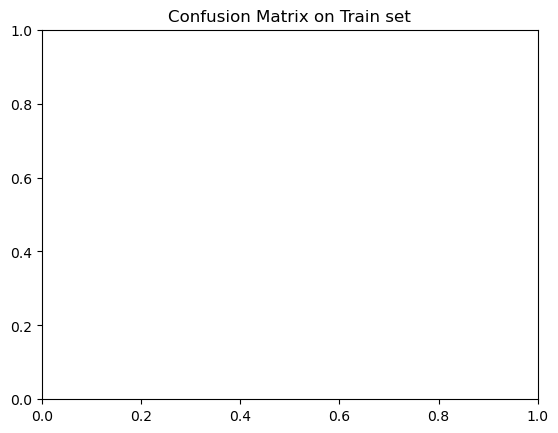

In [49]:
_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Train set"
)  
ConfusionMatrixDisplay.from_estimator(
    classifier, 
    X_train, 
    Y_train, 
    ax=ax,
)  
plt.show()


In [ ]:
# https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap

import plotly.figure_factory as ff

z = [[0.1, 0.3, 0.5, 0.2],
     [1.0, 0.8, 0.6, 0.1],
     [0.1, 0.3, 0.6, 0.9],
     [0.6, 0.4, 0.2, 0.2]]

x = ['healthy', 'multiple diseases', 'rust', 'scab']
y =  ['healthy', 'multiple diseases', 'rust', 'scab']

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'Le chat mange une souris',
    'Le chien aboie fort'
]

new_sentence = ['Le lion rugit']

# --------------------------
tokenizer_no_oov = Tokenizer(num_words=10)
tokenizer_no_oov.fit_on_texts(sentences)
print("Voc sans oov_token      :", tokenizer_no_oov.word_index)

sequence_no_oov = tokenizer_no_oov.texts_to_sequences(new_sentence)
print("Séquence sans oov_token :", sequence_no_oov)




# --------------------------
tokenizer_with_oov = Tokenizer(num_words=10, oov_token='<OOV>')
tokenizer_with_oov.fit_on_texts(sentences)
print("Voc avec oov_token      :", tokenizer_with_oov.word_index)

sequence_with_oov = tokenizer_with_oov.texts_to_sequences(new_sentence)
print("Séquence avec oov_token :", sequence_with_oov)




Voc sans oov_token      : {'le': 1, 'chat': 2, 'mange': 3, 'une': 4, 'souris': 5, 'chien': 6, 'aboie': 7, 'fort': 8}
Séquence sans oov_token : [[1]]
Voc avec oov_token      : {'<OOV>': 1, 'le': 2, 'chat': 3, 'mange': 4, 'une': 5, 'souris': 6, 'chien': 7, 'aboie': 8, 'fort': 9}
Séquence avec oov_token : [[2, 1, 1]]
